In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [2]:

pubg_data=pd.read_csv("N:\Machine learning\Pubg cheater detection\pubg_train_V2.csv")

# Lets look at our dataset
print(pubg_data.shape)
print(pubg_data.head())
print(pubg_data.info())


(4446966, 29)
               Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0          

 Now if you can see the dataset their is no column for cheaters prediction so our intial aim is to find the players who are cheating through data analysis and some domain knowledge. Afterwards we will add a column of cheaters in our orignal dataset and annot the data with respect to cheaters, then we will build our machine learning model to predict whether a player is cheating or not.
 Lets dive deeper into data and check the impurites present

### Pubg 


### - heading


In [3]:

               #--------removing any NaN values-------

print(pubg_data[pubg_data['winPlacePerc'].isnull()])


                     Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]


In [4]:
pubg_data.drop(2744604,inplace=True)

C:\Users\nimit\AppData\Local\Temp\ipykernel_6768\4040280872.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pubg_data.corr(),annot = True,cmap = "BuPu")


<Axes: >

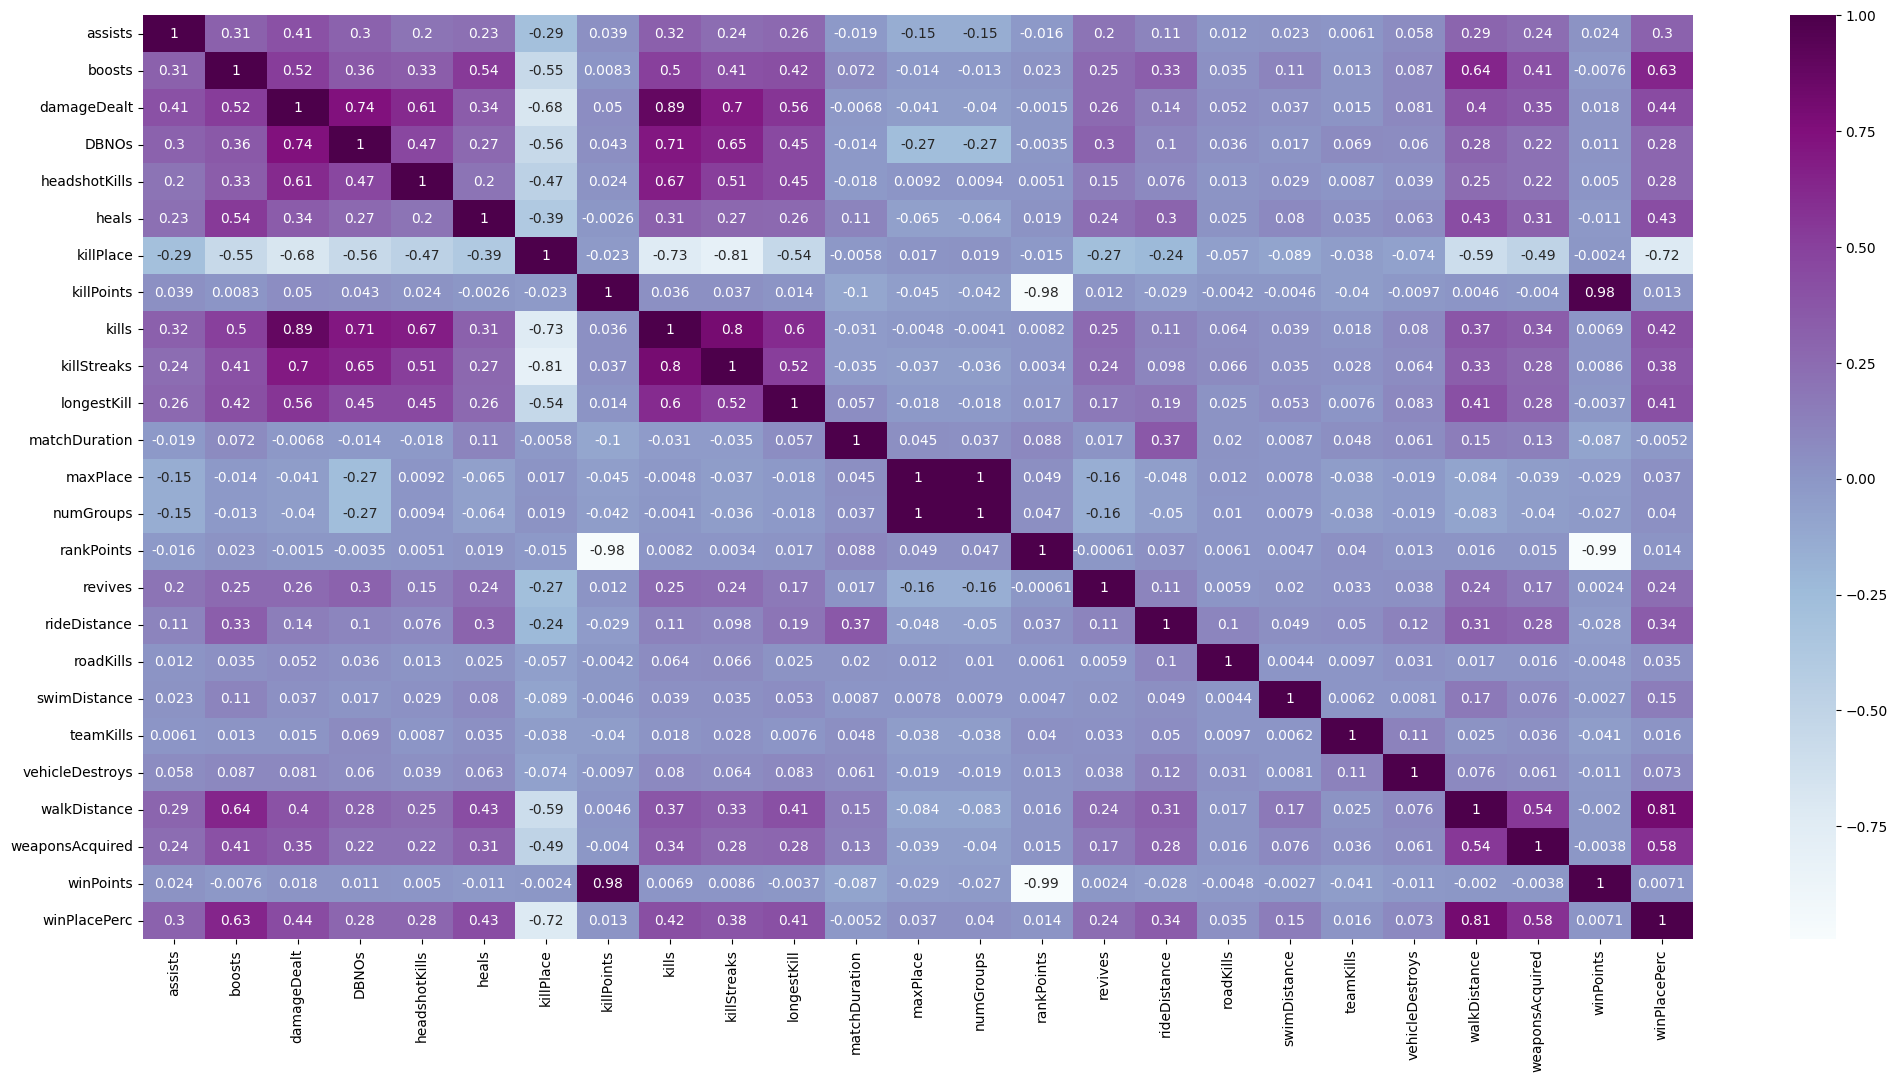

In [5]:
plt.figure(figsize=[25,12])
sns.heatmap(pubg_data.corr(),annot = True,cmap = "BuPu")

In [6]:
        #-----dropping categorical attributes as they are of no use for our prediction-------

pubg_data=pubg_data.drop(['Id','groupId', 'matchId','matchType'],axis=1)

If you have played any Battle Royal game you can understand that killing enemy without moving a single step is nearly not possible so these players might be potential cheaters so we are appending these players in cheaters_data.

In [7]:
            #---------using totaldistance attribute to sum up all the distances travelled by the player--------

pubg_data['totalDistance'] = pubg_data['rideDistance'] + pubg_data['walkDistance'] + pubg_data['swimDistance']

pubg_data['potential cheaters']=((pubg_data['kills'] > 0) & (pubg_data['totalDistance'] == 0))

cheaters_data=pubg_data[pubg_data['potential cheaters']==True]
pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)



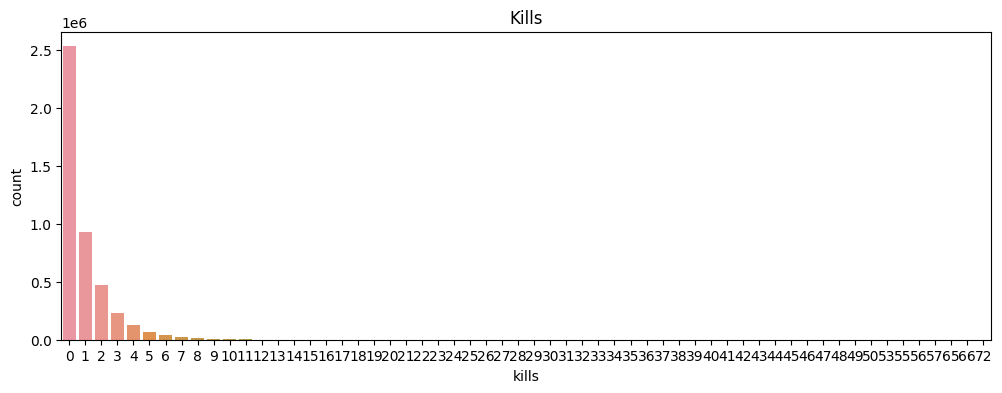

In [8]:

# chances of breaking the world record of 59 kills in PUBG single match is rare so we are marking those players as potential cheaters.

plt.figure(figsize=(12,4))
sns.countplot(data=pubg_data, x=pubg_data['kills']).set_title('Kills')
plt.show()

pubg_data['potential cheaters']=((pubg_data['kills'] > 59))
cheaters_data=pd.concat([cheaters_data,pubg_data[pubg_data['potential cheaters']==True]])

pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)


C:\Users\nimit\AppData\Local\Temp\ipykernel_6768\3390771298.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pubg_data['longestKill'],kde=True,color='orange')


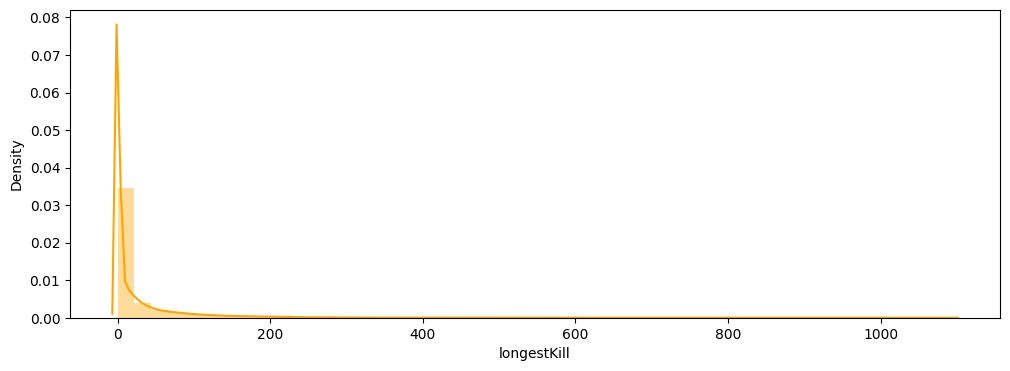

In [9]:

# # Killing an enemy from a distance of more than 1KM sounds insane until or unless you get on some vehicle and run away leaving your enemy to die but chances of this are very less so we can consider these players as potential cheaters

plt.figure(figsize=(12,4))
sns.distplot(pubg_data['longestKill'],kde=True,color='orange')
plt.show()

pubg_data['potential cheaters']=((pubg_data['longestKill'] >= 1000))
cheaters_data=pd.concat([cheaters_data,pubg_data[pubg_data['potential cheaters']==True]])

pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)


C:\Users\nimit\AppData\Local\Temp\ipykernel_6768\3972317804.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pubg_data['weaponsAcquired'], bins=10)


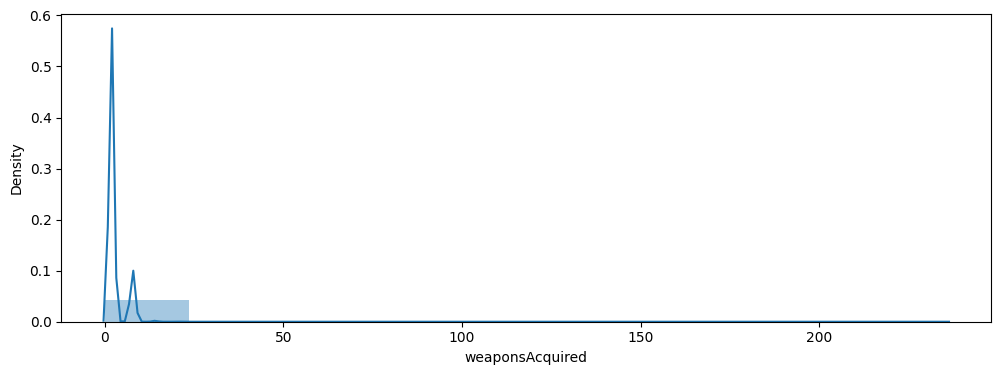

In [10]:
# in a single match a player can acquire on an average of 10-20 weapons so if someone is using more than 50 weapons then they can be considered as potential cheaters

plt.figure(figsize=(12,4))
sns.distplot(pubg_data['weaponsAcquired'], bins=10)
plt.show()


pubg_data['potential cheaters']=((pubg_data['weaponsAcquired'] >= 50))
cheaters_data=pd.concat([cheaters_data,pubg_data[pubg_data['potential cheaters']==True]])

pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)


In [11]:

# if a player is killing enemy without using a single weapon then their is something fishy about it so putting them in cheaters category will be more safer

pubg_data['potential cheaters']=((pubg_data['weaponsAcquired'] == 0) & (pubg_data['kills']>10))
cheaters_data=pd.concat([cheaters_data,pubg_data[pubg_data['potential cheaters']==True]])

pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)


C:\Users\nimit\AppData\Local\Temp\ipykernel_6768\867167112.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pubg_data['heals'], bins=10)


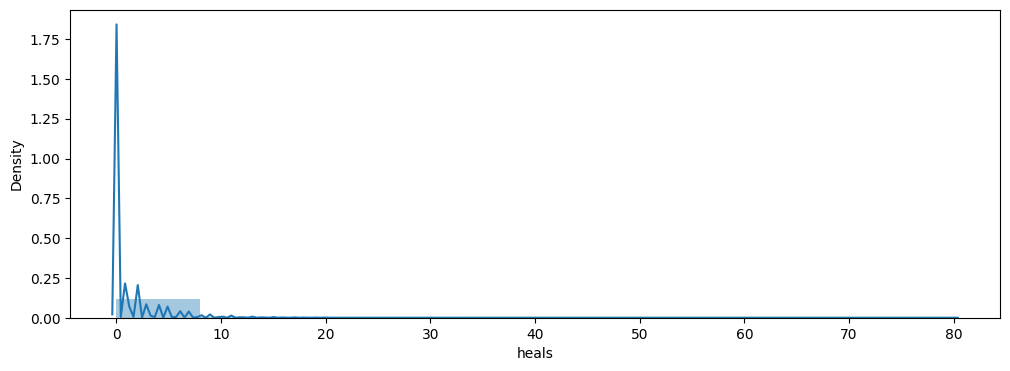

In [12]:

# on an average players do not use more than 25-30 heals in a single match sp we can put these players in cheaters category

plt.figure(figsize=(12,4))
sns.distplot(pubg_data['heals'], bins=10)
plt.show()

pubg_data['potential cheaters']=((pubg_data['heals'] >=30))
cheaters_data=pd.concat([cheaters_data,pubg_data[pubg_data['potential cheaters']==True]])

pubg_data.drop(pubg_data[pubg_data['potential cheaters']==True].index,inplace=True)

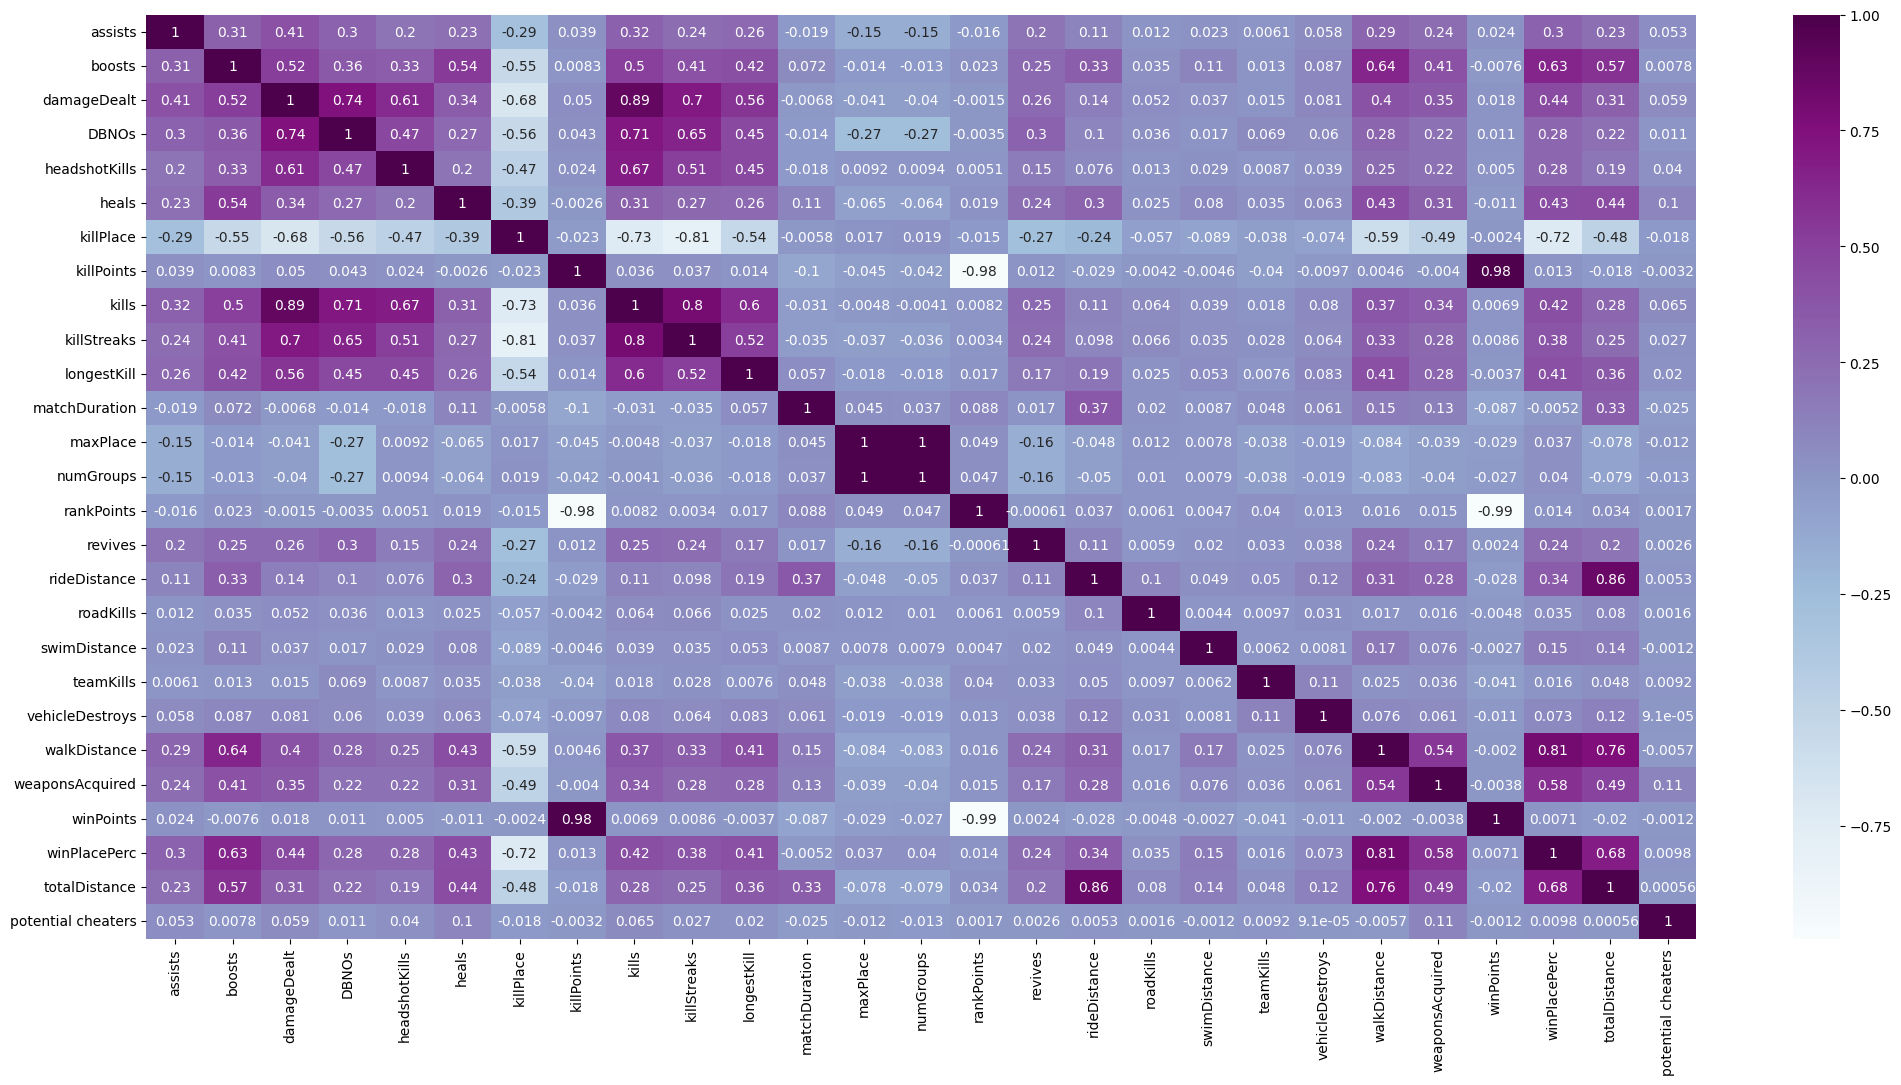

,assists,boosts,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,maxPlace,numGroups,rankPoints,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,totalDistance,potential cheaters
0,0,0,0,0,0,60,1241,0,0,0.00,...,28,26,-1,0,0,0,0,1,244.8000,False
1,0,0,0,0,0,57,0,0,0,0.00,...,26,25,1484,0,0,0,0,5,1445.0445,False
2,1,0,0,0,0,47,0,0,0,0.00,...,50,47,1491,0,0,0,0,2,161.8000,False
3,0,0,0,0,0,75,0,0,0,0.00,...,31,30,1408,0,0,0,0,3,202.7000,False
4,0,0,0,0,0,45,0,1,1,58.53,...,97,95,1560,0,0,0,0,2,49.7500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423005,0,8,0,1,33,4,0,4,1,142.80,...,94,91,1559,0,0,0,1,5,7924.0000,True
4435189,1,2,0,0,32,41,0,0,0,0.00,...,30,29,1572,1,0,0,0,10,10312.0000,True
4436938,0,3,0,0,36,42,0,0,0,0.00,...,92,86,1581,0,0,0,0,8,2834.1000,True
4438304,0,2,0,0,38,45,0,0,0,0.00,...,26,24,1457,1,0,0,0,3,3737.0000,True


In [13]:

pubg_data=pd.concat([pubg_data,cheaters_data])


plt.figure(figsize=[25,12])
sns.heatmap(pubg_data.corr(),annot = True,cmap = "BuPu")
plt.show()

pubg_data.drop(['damageDealt','winPoints','rideDistance','swimDistance','walkDistance','winPlacePerc'],axis=1)


In [14]:
# load the model
from sklearn.ensemble import RandomForestRegressor

pubg_data.dropna(inplace=True)

target=pubg_data['potential cheaters']
features=pubg_data.drop('potential cheaters',axis=1)
# split the dataset into test and train

x_train,x_test,y_train,y_test=train_test_split(features,target,train_size=0.3,random_state=0)


In [15]:

model=RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features='sqrt')

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
y_predtrain=model.predict(x_train)


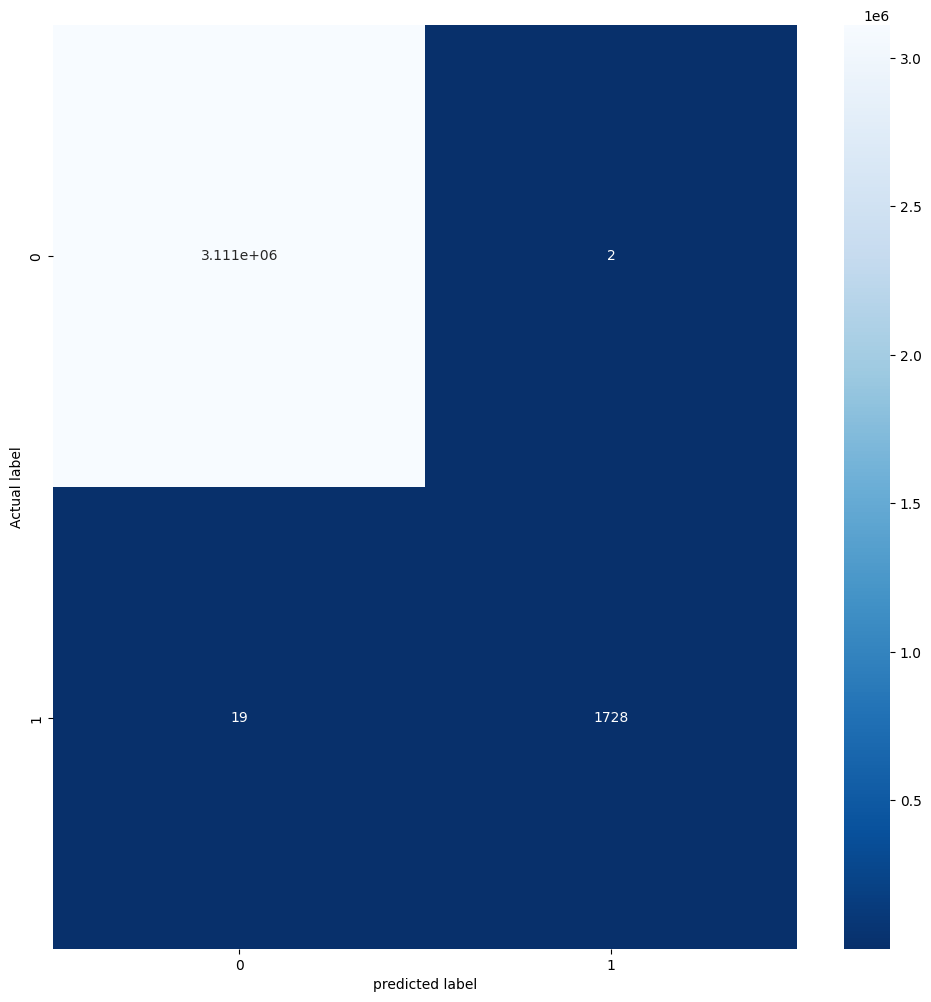

test data accuracy:  0.9999932538270075
test data precision score:  0.9988439306358381
test data recall score:  0.9891242129364625
test data f1 score:  0.9939603106125969
test data area under curve (auc):  0.994561785041508


In [16]:
# plot the confusion matrix
from sklearn import metrics
cm=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred,labels=model.classes_)

plt.figure(figsize=(12,12))
sns.heatmap(cm,annot=True,cmap='Blues_r',fmt='0.4g')
plt.ylabel('Actual label')
plt.xlabel('predicted label')
plt.show()

# evaluating the performance of the model on various parameters
print("test data accuracy: ", accuracy_score(y_test, y_pred))
print("test data precision score: ", precision_score(y_test, y_pred)) 
print("test data recall score: ", recall_score(y_test, y_pred))
print("test data f1 score: ", f1_score(y_test, y_pred))
print("test data area under curve (auc): ", roc_auc_score(y_test, y_pred))
     